In [11]:
import torch 
import monai
from torch import nn
import SimpleITK as sitk 
import numpy as np 
import matplotlib.pyplot as plt

In [12]:
image_array = sitk.GetArrayFromImage(sitk.ReadImage('Task09_Spleen/imagesTr/spleen_2.nii.gz'))

Text(0.5, 1.0, 'laplace filtered')

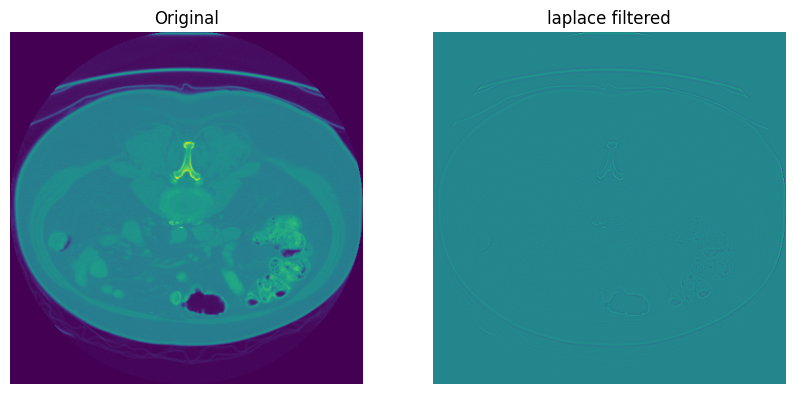

In [13]:
from skimage.filters import laplace

image = image_array[50] # use 50th slice for demo
output = laplace(image_array[50])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(output)
ax[1].axis('off')
ax[1].set_title('laplace filtered')


## Demo of convolutional layer

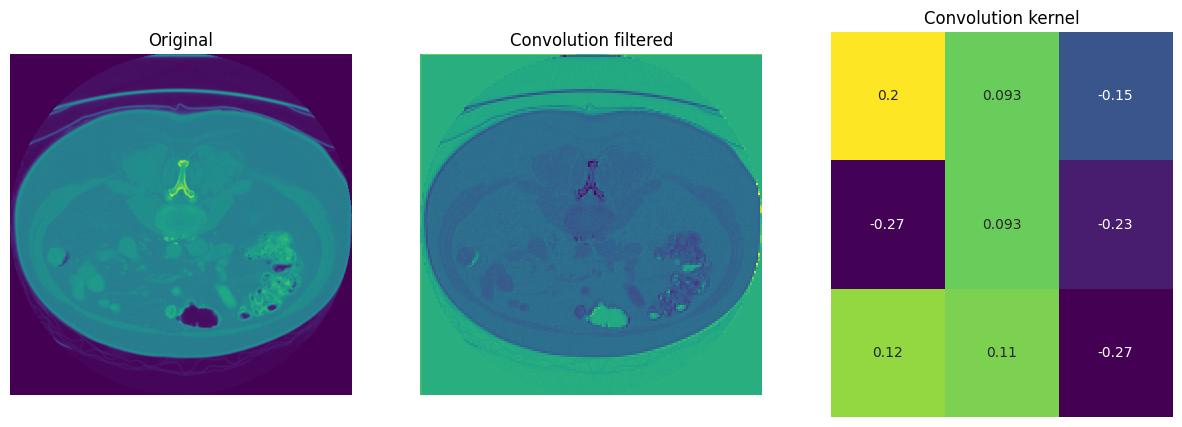

In [20]:
import seaborn as sns 

image_tensor = torch.tensor(image_array[50])[None, None, ...].float()

with torch.no_grad():
    layer = torch.nn.Conv2d(1, 4, 3, 3, 1)
    out = layer(image_tensor)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image_tensor[0,0])
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(out[0, 0])
    ax[1].axis('off')
    ax[1].set_title('Convolution filtered')
    
    sns.heatmap(
        layer.weight[0,0], 
        ax=ax[2], 
        cmap='viridis', 
        annot=True, 
        cbar=False
    )
    ax[2].axis('off')
    ax[2].set_title('Convolution kernel')



In [39]:
# Helpers

class UpsampleLayer(nn.Module): 
    def forward(self, x): 
        B, N, H, W, D = x.shape
        return torch.nn.functional.interpolate(x, (H * 2, W * 2, D * 2))


class EncoderBlock(nn.Module): 
    def __init__(self, input_dimension, output_dimension): 
        super().__init__()
        # conv 
        self.conv = torch.nn.Conv3d(input_dimension, output_dimension, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.activation = torch.nn.ReLU()
        self.norm = torch.nn.BatchNorm3d(output_dimension)
        self.pool = torch.nn.MaxPool3d(kernel_size=(2, 2, 2))

    def forward(self, x): 
        x = self.conv(x)
        x = self.activation(x)
        x = self.norm(x)
        x = self.pool(x)

        return x


class DecoderBlock(nn.Module): 
    def __init__(self, input_dimension, output_dimension): 
        super().__init__()
        # conv 
        self.conv = torch.nn.Conv3d(input_dimension, output_dimension, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.activation = torch.nn.ReLU()
        self.norm = torch.nn.BatchNorm3d(output_dimension)
        self.pool = UpsampleLayer()

    def forward(self, x): 
        x = self.conv(x)
        x = self.activation(x)
        x = self.norm(x)
        x = self.pool(x)

        return x


class EncoderDecoderConvNet(nn.Module): 
    def __init__(self, num_classes=1): 
        super().__init__()
        self.blocks = torch.nn.ModuleList()
        self.blocks.append(
            EncoderBlock(1, 32), # B C H W D -> B 32 H/2 W/2 D/2
        )
        self.blocks.append(
            EncoderBlock(32, 64)
        )
        self.blocks.append(
            EncoderBlock(64, 128)
        )

        self.blocks.append(
            DecoderBlock(128, 64)
        )
        self.blocks.append(
            DecoderBlock(64, 32)
        )
        self.blocks.append(
            DecoderBlock(32, num_classes)
        )

    def forward(self, x): 
        for block in self.blocks:
            x = block(x)
        return x





In [40]:
inp = torch.randn(1, 1, 64, 64, 64)
block = EncoderBlock(1, 32)
block(inp).shape

torch.Size([1, 32, 32, 32, 32])

In [41]:
inp = torch.randn(1, 1, 64, 64, 64)
block = DecoderBlock(1, 32)
block(inp).shape

torch.Size([1, 32, 128, 128, 128])

In [43]:
inp = torch.randn(1, 1, 64, 64, 64)
net = EncoderDecoderConvNet(2)

net(inp).shape

torch.Size([1, 2, 64, 64, 64])

In [6]:
from models import EncoderDecoderNetwork

model = EncoderDecoderNetwork() # Randomly initialized model

first_layer_conv_filters = model.layers[0].conv.weight.data.detach()
print(first_layer_conv_filters.shape) # num_filters, input_chanels, H, W, D

torch.Size([16, 1, 3, 3, 3])


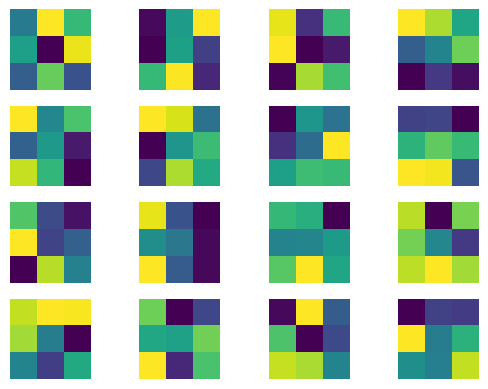

In [7]:
fig, ax = plt.subplots(4, 4)
ax = ax.flatten()
for i in range(16): 
    ax[i].axis('off')
    ax[i].imshow(first_layer_conv_filters[i, 0, ..., 0])

In [8]:
model.load_state_dict(torch.load('encoder_decoder_spleen_seg.pt'))

<All keys matched successfully>

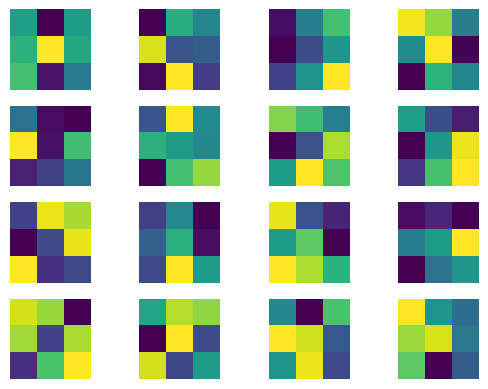

In [9]:
fig, ax = plt.subplots(4, 4)
ax = ax.flatten()
for i in range(16): 
    ax[i].axis('off')
    ax[i].imshow(first_layer_conv_filters[i, 0, ..., 0])

/Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


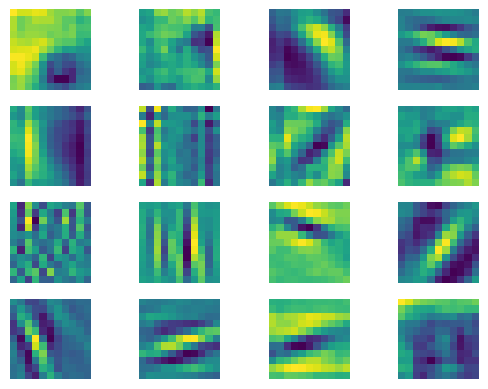

In [10]:
from torchvision.models.alexnet import alexnet

model = alexnet(pretrained=True)
first_layer_conv_filters = model.features[0].weight.data.detach()

fig, ax = plt.subplots(4, 4)
ax = ax.flatten()
for i in range(16): 
    ax[i].axis('off')
    ax[i].imshow(first_layer_conv_filters[i, 0, ...])